# Upper Confidence Bound (UCB)

## Algorithm Steps

### **Step 1.**  
At each round $n$, we consider two numbers for each ad $i$:  
- $N_i(n)$ - the number of times the ad $i$ was selected up to round $n$.  
- $R_i(n)$ - the sum of rewards of the ad $i$ up to round $n$.  

### **Step 2.**  
From these two numbers, we compute:  

- The **average reward** of ad $i$ up to round $n$:  

  $$
  \bar{r}_i(n) = \frac{R_i(n)}{N_i(n)}
  $$

- The **confidence interval** $[ \bar{r}_i(n) - \Delta_i(n), \bar{r}_i(n) + \Delta_i(n) ]$ at round $n$, where:  

  $$
  \Delta_i(n) = \sqrt{\frac{3 \log(n)}{2 N_i(n)}}
  $$

### **Step 3.**  
We select the ad $i$ that has the **maximum UCB value**:  

$$
\bar{r}_i(n) + \Delta_i(n)
$$


## Goal

The goal of training the Upper Confidence Bound (UCB) algorithm for selecting the best advertisement is to maximize the total number of clicks by balancing exploration and exploitation.

![](./pic/ads.png)

In [1]:
colors ={ 'tab:blue': '#1f77b4',
          'tab:orange': '#ff7f0e',
          'tab:green': '#2ca02c',
          'tab:red': '#d62728',
          'tab:purple': '#9467bd',
          'tab:brown': '#8c564b',
          'tab:pink': '#e377c2',
          'tab:gray': '#7f7f7f',
          'tab:olive': '#bcbd22',
          'tab:cyan': '#17becf'}

## Libraries Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [3]:
%cat '../00_data/Ads_CTR_Optimisation.csv'|head

Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
1,0,0,0,1,0,0,0,1,0
0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
cat: stdout: Broken pipe


In [4]:
%cat '../00_data/Ads_CTR_Optimisation.csv'|tail

0,0,0,1,0,0,0,0,0,0
0,1,0,1,1,0,1,0,0,0
0,0,0,1,0,0,1,0,0,0
0,0,0,0,1,0,0,0,1,0
0,0,1,0,0,0,0,0,1,0
0,0,1,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0
0,1,0,0,0,0,0,0,0,0

## Data Loading

In [5]:
data = pd.read_csv("../00_data/Ads_CTR_Optimisation.csv")

data.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [6]:
data.shape

(10000, 10)

## Implementing UCB

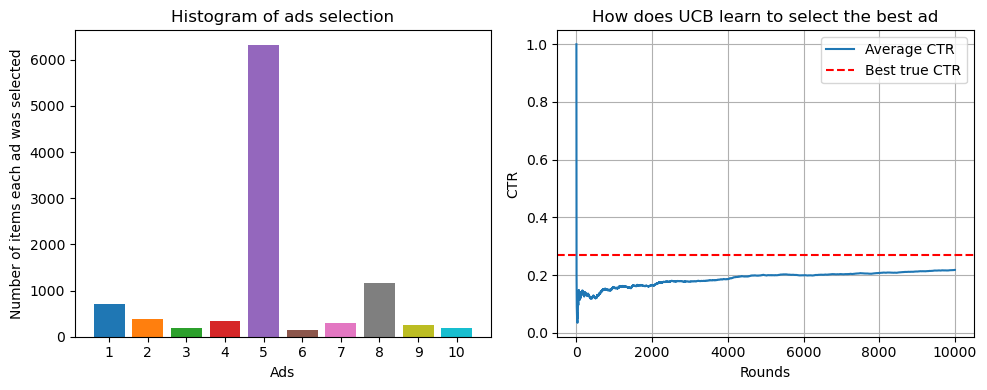

In [7]:
max_rounds, max_ads = data.shape          # Number of rounds, number of ads
ads_selected  = []                        # index of selected ad during the round
number_of_selections = np.zeros(max_ads)  # counter of selection per each ad
sums_of_rewards = np.zeros(max_ads)       # sums of rewards per each ad
total_reward = []                         # reward per each round

for n in np.arange(0, max_rounds):
    ad = 0
    max_upper_bound = 0
    for i in np.arange(0, max_ads):
        if number_of_selections[i] > 0:
            average_reward = sums_of_rewards[i] / number_of_selections[i]
            delta = np.sqrt(3/2 * np.log(n + 1) / number_of_selections[i])
            upper_bound = average_reward + delta
        else:
            upper_bound = np.inf
        
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i
            
    ads_selected.append(ad)
    number_of_selections[ad] += 1
    reward = data.values[n, ad]
    sums_of_rewards[ad] += reward
    total_reward.append(reward)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
bins = np.arange(max_ads)
counts = np.bincount(ads_selected, minlength=max_ads)  # Count occurrences
axes[0].bar(bins+1, counts, color = colors)
axes[0].set_title("Histogram of ads selection")
axes[0].set_xlabel("Ads")
axes[0].set_ylabel("Number of items each ad was selected")
axes[0].set_xticks(np.arange(1, 11))

true_ctr = np.sum(data.values, axis=0) / max_rounds  
axes[1].plot(np.cumsum(total_reward) / (np.arange(max_rounds) + 1), label="Average CTR")
axes[1].axhline(y=max(true_ctr), linestyle="--", color="red", label="Best true CTR")
axes[1].set_xlabel("Rounds")
axes[1].set_ylabel("CTR")
axes[1].set_title("How does UCB learn to select the best ad")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

## Animate the learning process

In [8]:
import matplotlib.animation as animation

max_rounds, max_ads = data.shape          # Number of rounds, number of ads
ads_selected  = []                        # index of selected ad during the round
number_of_selections = np.zeros(max_ads)  # counter of selection per each ad
sums_of_rewards = np.zeros(max_ads)       # sums of rewards per each ad
total_reward = []                         # reward per each round

# UCB learning
for n in np.arange(0, max_rounds):
    ad = 0
    max_upper_bound = 0
    for i in np.arange(0, max_ads):
        if number_of_selections[i] > 0:
            average_reward = sums_of_rewards[i] / number_of_selections[i]
            delta = np.sqrt(3/2 * np.log(n + 1) / number_of_selections[i])
            upper_bound = average_reward + delta
        else:
            upper_bound = np.inf
        
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i
            
    ads_selected.append(ad)
    number_of_selections[ad] += 1
    reward = data.values[n, ad]
    sums_of_rewards[ad] += reward
    total_reward.append(reward)
 
rounds = np.arange(250, max_rounds + 250, 250)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# hist settings
axes[0].set_xlabel("Ads")
axes[0].set_ylabel("Number of items each ad was selected")
axes[0].set_ylim([0, max_rounds])

true_ctr = np.sum(data.values, axis=0) / max_rounds  

bins = np.arange(max_ads)

def update_hist(rnds):
    plt.cla()
    # plot hist
    counts = np.bincount(ads_selected[0:rnds], minlength=max_ads)  # Count occurrences
    hist_atrs = axes[0].bar(bins+1, counts, color = colors)
    axes[0].set_title(f"Histogram of ads selection ({rnds} rounds)")
    axes[0].set_xticks(np.arange(1, 11))
    # plot line
    line_arts = axes[1].plot(np.cumsum(total_reward[0:rnds]) / (np.arange(rnds) + 1), label="Average CTR")
    axes[1].axhline(y=max(true_ctr), linestyle="--", color="red", label="Best true CTR")
    axes[1].set_title(f"How does UCB learn to select the best ad ({rnds} rounds)")
    axes[1].set_xlim([-250, max_rounds])
    axes[1].set_xlabel("Rounds")
    axes[1].set_ylabel("CTR")
    axes[1].legend()
    axes[1].grid()
    
    return hist_atrs.patches + line_arts
    
animation = animation.FuncAnimation(fig, update_hist, rounds, interval=200, blit=True)
animation.save(filename="./pic/UCB_demo.gif", writer='pillow')

#plt.show()
plt.close()

![](./pic/UCB_demo.gif) 